In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ewaldnn2d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"
N_batch = 100
N_epochs = 10000
lr = 1e-1 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 100    # epochs to wait for improvement before stopping training'
pad_mode = "reflect" # in this example, we use reflective padding for local feature generation
N_pow = 1 # number of local features per grid point
N_train = 1500
N_test = 250
N_val = 250
N_energy_terms = 1 # number of energy terms for the LERN model

# grid and basis settings
N_x = 32 # number of grid points in x direction
N_y = N_x # number of grid points in y direction
m_x = torch.arange(0, N_x, dtype=dtype, device=device)             # (N_x,)
m_y = torch.arange(0, N_y, dtype=dtype, device=device)             # (N_y,)
abs_val = torch.sqrt(m_x[:, None]**2 + m_y[None, :]**2)  # (M_x, M_y)
x = torch.linspace(0, 1, N_x, dtype=dtype, device=device)            # (N_x,)
y = torch.linspace(0, 1, N_y, dtype=dtype, device=device)            # (N_y,)
DM_x = torch.cos(torch.pi * torch.outer(m_x, x))                  # (M_x, N_x)
DM_y = torch.cos(torch.pi * torch.outer(m_y, y))                  # (M_y, N_y)
DerDM_x = -torch.pi * m_x[:, None] * torch.sin(torch.pi * torch.outer(m_x, x))  # (M_x, N_x) # derivative of design matrix
DerDM_y = -torch.pi * m_y[:, None] * torch.sin(torch.pi * torch.outer(m_y, y))  # (M_y, N_y) # derivative of design matrix

data_regime = "smooth" # "smooth" or "rough"
if data_regime == "smooth":
    M_cutoff = 10 # maximum harmonic   
    std_harm = 2.0 / (1.0 + 0.2 * abs_val)**2 * (abs_val <= M_cutoff).double()  # (M_x, M_y)
elif data_regime == "rough":
    std_harm = 2.0 / (1.0 + 0.0 * abs_val)**2 # (M_x, M_y)
else:
    raise ValueError("regime must be 'smooth' or 'rough'")
std_harm[0, 0] = 0.0 # no uniform density offset

# kinetic energy parameters
alpha = 0.1
beta = -0.01

# interaction kernel parameters
qs = 0.1 # screening momentum
amp = 1.0 # amplitude of interaction kernel
kernel_regime = "screened_coulomb"

# screened total energy function
def E_int(rho: torch.Tensor, d_rho_x: torch.Tensor, d_rho_y: torch.Tensor, eng_dens_flag: bool = False) -> torch.Tensor:
        return amp * E_int_ms_dct(rho, kernel=kernel_regime, eng_dens_flag=eng_dens_flag, qs=qs)


rho = torch.randn((10, N_x, N_y), dtype=dtype, device=device)  # dummy density input
d_rho_x = torch.randn((10, N_x, N_y), dtype=dtype, device=device)  # dummy density gradient input
d_rho_y = torch.randn((10, N_x, N_y), dtype=dtype, device=device)  # dummy density gradient input    


E = E_kin_custom(
        rho=rho, 
        d_rho_x=d_rho_x, 
        d_rho_y=d_rho_y, 
        alpha=alpha, 
        beta=beta, 
        qs=qs,
        eng_dens_flag=False
        )

print(E)


# # generate train/test split
# flag_generate_data = True # if True, generate new data; if False, load existing data from disk
# if flag_generate_data:
#     N_batch_int = 10 # number of density profiles per data generation batch
#     torch.manual_seed(1234) # for reproducibility
#     rho_train, d_rho_x_train, d_rho_y_train, a_train, E_loc_HF_train, E_SC_train = generate_SC_data_2d(N_train, N_batch_int, E_HF, E_SC, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)
#     rho_test, d_rho_x_test, d_rho_y_test, a_test, E_loc_HF_test, E_SC_test = generate_SC_data_2d(N_test, N_batch_int, E_HF, E_SC, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 
#     rho_val, d_rho_x_val, d_rho_y_val, a_val, E_loc_HF_val, E_SC_val = generate_SC_data_2d(N_val, N_batch_int, E_HF, E_SC, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)  
#     # save data to disk
#     os.makedirs("DATA2d", exist_ok=True)

#     fname = f"DATA2d/LERN_dataset_{data_regime}_{kernel_regime}_{qs}_{amp}_{N_x}_{N_y}.pt"

#     torch.save(
#         {
#             "rho_train": rho_train,
#             "d_rho_x_train": d_rho_x_train,
#             "d_rho_y_train": d_rho_y_train,
#             "a_train": a_train,
#             "E_loc_HF_train": E_loc_HF_train,
#             "E_SC_train": E_SC_train,
#             "rho_val": rho_val,
#             "d_rho_x_val": d_rho_x_val,
#             "d_rho_y_val": d_rho_y_val,
#             "a_val": a_val,
#             "E_loc_HF_val": E_loc_HF_val,
#             "E_SC_val": E_SC_val,
#             "rho_test": rho_test,
#             "d_rho_x_test": d_rho_x_test,
#             "d_rho_y_test": d_rho_y_test,
#             "a_test": a_test,
#             "E_loc_HF_test": E_loc_HF_test,
#             "E_SC_test": E_SC_test,
#             "data_regime": data_regime,
#             "kernel_regime": kernel_regime,
#         },
#         fname,
#     )
# else:
#     data = torch.load(f"DATA2d/LERN_dataset_{data_regime}_{kernel_regime}_{qs}_{amp}_{N_x}_{N_y}.pt")
#     rho_train = data["rho_train"]
#     E_loc_HF_train = data["E_loc_HF_train"]
#     E_SC_train = data["E_SC_train"]
#     rho_test = data["rho_test"]
#     E_loc_HF_test = data["E_loc_HF_test"]
#     E_SC_test = data["E_SC_test"]
#     rho_val = data["rho_val"]
#     E_loc_HF_val = data["E_loc_HF_val"]
#     E_SC_val = data["E_SC_val"]

# features_train = generate_loc_features_rs(rho_train, N_pow=N_pow)  # (N_train, N_x, N_y, N_pow)
# features_test  = generate_loc_features_rs(rho_test, N_pow=N_pow)   # (N_test, N_x, N_y, N_pow)
# features_val   = generate_loc_features_rs(rho_val, N_pow=N_pow)    # (N_val, N_x, N_y, N_pow)

# # Extend features with neighbor information
# R_feat = 1.0 # radius for neighbor feature extension
# features_train = extend_features_neighbors_2d(features_train, R=R_feat)
# features_test  = extend_features_neighbors_2d(features_test, R=R_feat)
# features_val   = extend_features_neighbors_2d(features_val, R=R_feat)

# # Normalize features
# mean_feat, std_feat = compute_normalization_stats(features_train)
# features_train_norm = normalize_features(features_train, mean_feat, std_feat)
# features_test_norm = normalize_features(features_test, mean_feat, std_feat)
# features_val_norm = normalize_features(features_val, mean_feat, std_feat)

# # Supplement the features with the unnormalized HF energy term (for the LERN model)
# features_train_norm = torch.cat([features_train_norm, E_loc_HF_train], dim=-1)  # (N_train, N_x, N_y, N_feat + 1)
# features_test_norm  = torch.cat([features_test_norm,  E_loc_HF_test], dim=-1)   # (N_test,  N_x, N_y, N_feat + 1)
# features_val_norm   = torch.cat([features_val_norm,   E_loc_HF_val], dim=-1)    # (N_val,   N_x, N_y, N_feat + 1)

# # Normalize targets
# E_mean = E_SC_train.mean()
# E_std = E_SC_train.std()
# E_SC_train_norm = (E_SC_train - E_mean) / E_std
# E_SC_test_norm = (E_SC_test - E_mean) / E_std
# E_SC_val_norm = (E_SC_val - E_mean) / E_std
# # Datasets
# train_dataset = TensorDataset(features_train_norm, E_SC_train_norm)
# val_dataset   = TensorDataset(features_val_norm,   E_SC_val_norm)
# test_dataset  = TensorDataset(features_test_norm,  E_SC_test_norm)
# # Loaders
# train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
# val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
# test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)

# _, _, _, N_feat = features_train.shape
# print(f"Number of local features per grid point: {N_feat}")

tensor([0.9782, 0.9945, 0.9939, 1.0017, 1.0117, 0.9582, 0.9881, 1.0325, 0.9249,
        0.9591], dtype=torch.float64)


In [2]:
ckpt_dir = "LearningSC2d_checkpoints"
flag_train = True  # set to True to train models
learning_regime = "LERN2d"

n_hidden_list = [1, 2, 3, 4]
n_neurons_list = [8, 16, 32, 64]

if flag_train:
    for n_hidden in n_hidden_list:
        for n_neurons in n_neurons_list:
            for seed in range(3): # train a few models with different random seeds

                torch.manual_seed(1234 + seed)
                run_name = f"LERN2d_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}_{N_feat}_{N_energy_terms}_{n_hidden}_{n_neurons}_{seed}"
                print(f"Training model: n_hidden={n_hidden}, n_neurons={n_neurons}, seed={seed}")

                model = LERN2d(
                        N_x=N_x,
                        N_y=N_y,
                        N_energy_terms=N_energy_terms,
                        N_feat=N_feat,
                        n_hidden=n_hidden,
                        n_neurons=n_neurons,
                        mean_feat=mean_feat,
                        std_feat=std_feat,
                        E_mean=E_mean,
                        E_std=E_std,
                    ).to(device=device, dtype=dtype)

                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.MSELoss()

                # Reduce LR when val loss plateaus
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.5, patience=50, cooldown=2, min_lr=1e-6
                )

                hist, best_epoch = train_with_early_stopping(
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    max_epochs=N_epochs,
                    patience=patience,
                    min_delta=min_delta,
                    ckpt_dir=ckpt_dir,
                    run_name=run_name,
                    learning_regime=learning_regime,
                    N_x=N_x,
                    N_y=N_y,
                    device=device,
                )

Training model: n_hidden=1, n_neurons=8, seed=0
[0001] train=0.529612 | val=0.030813 | best_val=0.030813 (epoch 1)
[0010] train=0.022045 | val=0.028903 | best_val=0.027432 (epoch 3)
[0020] train=0.022048 | val=0.028143 | best_val=0.027227 (epoch 16)
[0030] train=0.022072 | val=0.033391 | best_val=0.026915 (epoch 29)
[0040] train=0.023355 | val=0.031706 | best_val=0.026529 (epoch 39)
[0050] train=0.023123 | val=0.034007 | best_val=0.026429 (epoch 48)
[0060] train=0.022281 | val=0.026795 | best_val=0.025952 (epoch 59)
[0070] train=0.023091 | val=0.025092 | best_val=0.025092 (epoch 70)
[0080] train=0.023853 | val=0.025326 | best_val=0.025092 (epoch 70)
[0090] train=0.021472 | val=0.024849 | best_val=0.024849 (epoch 90)
[0100] train=0.025299 | val=0.025346 | best_val=0.024849 (epoch 90)
[0110] train=0.022331 | val=0.026468 | best_val=0.024571 (epoch 106)
[0120] train=0.025802 | val=0.033038 | best_val=0.024571 (epoch 106)
[0130] train=0.023415 | val=0.027183 | best_val=0.024457 (epoch 124)

In [3]:
best_val = math.inf
n_hidden_best = 0
n_neurons_best = 0 
seed_best = 0
for n_hidden in n_hidden_list:
    for n_neurons in n_neurons_list:
        for seed in range(3): # trained 3 models with different random seeds

            run_name = f"LERN2d_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}_{N_feat}_{N_energy_terms}_{n_hidden}_{n_neurons}_{seed}"
            model, normalization, epoch, val_loss = load_checkpoint(
                ckpt_dir + f"/{run_name}_best.pt",
                LERN2d,
                device=device
                )
            model = model.to(device=device, dtype=dtype)

            print(f"Model {run_name}: best val loss = {val_loss:.6f} at epoch {epoch}")
            if val_loss < best_val:
                best_val = val_loss
                n_hidden_best = n_hidden
                n_neurons_best = n_neurons
                seed_best = seed

            print(f"Best model: n_hidden={n_hidden_best}, n_neurons={n_neurons_best}, seed={seed_best}, val_loss={best_val:.6f}")

print("\n")
print("Overall best model:")
print(f"Best model: n_hidden={n_hidden_best}, n_neurons={n_neurons_best}, seed={seed_best}, val_loss={best_val:.6f}")

Model LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_8_0: best val loss = 0.023583 at epoch 473
Best model: n_hidden=1, n_neurons=8, seed=0, val_loss=0.023583
Model LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_8_1: best val loss = 0.023150 at epoch 256
Best model: n_hidden=1, n_neurons=8, seed=1, val_loss=0.023150
Model LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_8_2: best val loss = 0.022254 at epoch 218
Best model: n_hidden=1, n_neurons=8, seed=2, val_loss=0.022254
Model LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_16_0: best val loss = 0.023409 at epoch 240
Best model: n_hidden=1, n_neurons=8, seed=2, val_loss=0.022254
Model LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_16_1: best val loss = 0.021333 at epoch 322
Best model: n_hidden=1, n_neurons=16, seed=1, val_loss=0.021333
Model LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_16_2: best val loss = 0.021215 at epoch 245
Best model: n_hidden=1, n_neurons=16, seed=2, val_loss=0.021215
Model LERN2d_smoo

   epoch  train_loss  val_loss
0      1    0.741932  0.119499
1      2    0.142976  0.103005
2      3    0.109692  0.090328
3      4    0.077298  0.041176
4      5    0.034129  0.061405


<Axes: title={'center': 'LERN2d_smooth_screened_coulomb_0.1_1.0_32_32_5_1_1_16_2'}, xlabel='epoch'>

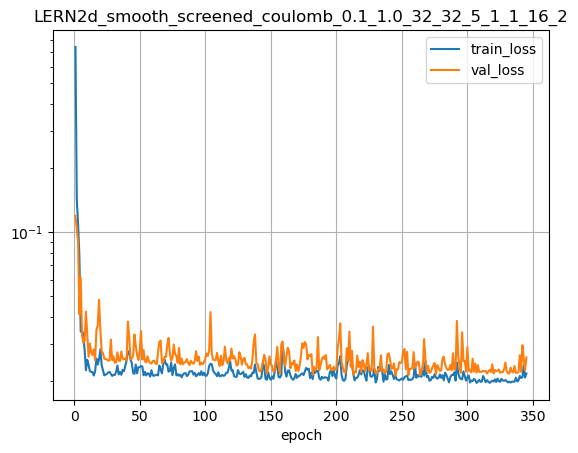

In [4]:
n_hidden = n_hidden_best
n_neurons = n_neurons_best
seed = seed_best

run_name = f"LERN2d_" + data_regime + '_' + kernel_regime + f"_{qs}_{amp}_{N_x}_{N_y}_{N_feat}_{N_energy_terms}_{n_hidden}_{n_neurons}_{seed}"

path = ckpt_dir + f"/{run_name}_history.csv"
hist_df = pd.read_csv(path)
print(hist_df.head())
hist_df.plot(x="epoch", y=["train_loss", "val_loss"], logy=True, grid=True, title=run_name)

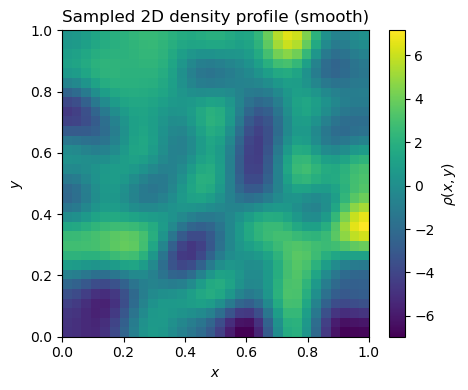

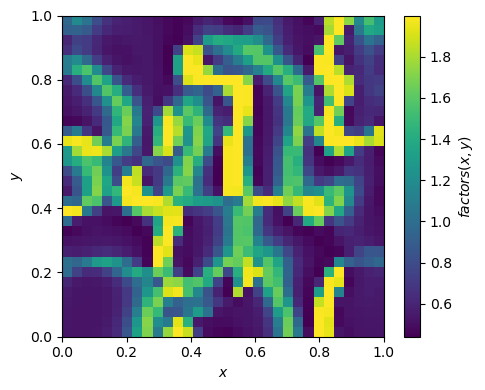

In [5]:
model, normalization, epoch, val_loss = load_checkpoint(
        ckpt_dir + f"/{run_name}_best.pt",
        LERN2d,
        device=device
    )
model = model.to(device=device, dtype=dtype)

k = 0  # index of the test sample to visualize
features_example = features_test_norm[k:k+1, :, :, :N_feat]  # (1, N_x, N_y, N_feat)
factors = model.local_nn(features_example) # (1, N_x, N_y, N_energy_terms)
rho_example = rho_test[k:k+1, :, :]  # (1, N_x, N_y)

plt.figure(figsize=(5, 4))
im = plt.imshow(
    rho_example.numpy().squeeze().T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$\rho(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
if data_regime == "rough":
    plt.title("Sampled 2D density profile (rough)")
elif data_regime == "smooth":
    plt.title("Sampled 2D density profile (smooth)")
plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 4))
im = plt.imshow(
    factors.detach().numpy().squeeze().T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$factors(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout()
plt.show()

(256000,)


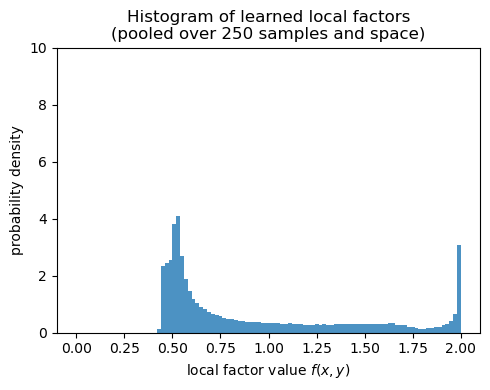

In [6]:
dummy_factors = []
k = 0  # index of the test sample to visualize
for k in range(N_test):
    features_example = features_test_norm[k:k+1, :, :, :N_feat]  # (1, N_x, N_y, N_feat)
    factors = model.local_nn(features_example) # (1, N_x, N_y, 1)
    factors = factors.squeeze().view(-1) # (N_x * N_y,)
    dummy_factors.append(factors.detach().cpu().numpy())


all_factors = np.concatenate(dummy_factors, axis=0)
print(all_factors.shape)   # (N_test * 32 * 32,)

n_bins = 100   # 50–100 is typical
bins = np.linspace(0.0, 2.0, n_bins + 1)

plt.figure(figsize=(5, 4))
plt.hist(
    all_factors,
    bins=bins,
    density=True,     # normalize → probability density
    alpha=0.8
)
plt.xlim(-0.1, 2.1)
plt.ylim(0, 10)
plt.xlabel(r"local factor value $f(x,y)$")
plt.ylabel("probability density")
plt.title(f"Histogram of learned local factors\n"
          rf"(pooled over {N_test} samples and space)")
plt.tight_layout()
plt.show()
